# High-level interface

Our data is in 216 blocks of 1024 x 1024 x 1024 voxels. It would be real nice to be able to manipulate the full volume using a high-level interface. We will lazily assemble a volume out of the 216 blocks and do a simple operation: we will visualize one neuron. We will find all voxels that match the target neuron id and count their numbers along the z axis using a reduction. This will give us the outline of the cell via an orthographic projection.

In [1]:
import collections
import dask
import gcsfs
import h5py
import io
import numba
import numpy as np
import os
import os.path
import pickle
import requests

import os.path
import dask.array as da
import xarray as xr

from dask.distributed import Client
from dask_kubernetes import KubeCluster
from numba.typed import Dict

In [2]:
with open('../.gcs_tokens', 'rb') as f:
    credentials = pickle.load(f)
credentials = credentials[list(credentials.keys())[0]]
fs = gcsfs.GCSFileSystem(project='neuron-jungle', token=credentials)
fs.ls('l4dense/neuron-volume')[:10]

['l4dense/neuron-volume/x3y5z1.hdf5',
 'l4dense/neuron-volume/x1y7z1.hdf5',
 'l4dense/neuron-volume/x0y0z2.hdf5',
 'l4dense/neuron-volume/x3y4z2.hdf5',
 'l4dense/neuron-volume/x4y3z0.hdf5',
 'l4dense/neuron-volume/x5y0z0.hdf5',
 'l4dense/neuron-volume/x5y2z3.hdf5',
 'l4dense/neuron-volume/x4y5z2.hdf5',
 'l4dense/neuron-volume/x2y0z2.hdf5',
 'l4dense/neuron-volume/x4y2z1.hdf5']

# Transform to zarr

Currently, the data is in the form of hdf5 chunks. We want to transform it so it can easily be read in the cloud in the chunked format. We follow a similar scheme to https://pangeo.io/data.html:

1. We locally mirror the data
2. We save it as a zarr
3. We upload it to the cloud (GCS)

In step 2, I've had better luck with using defered computation (`compute=False`) as well as metadata consolidation (`consolidated=True`); eager computation led to out of memory errors and my kernel died. YMMV.

Importantly, we will do this locally with one worker thread (multiple local threads give me killed worker errors; multiple remote threads also crash because they don't have a local mirror of the data). Once we upload the zarr to the cloud, we will be able to manipulate it without pulling it locally directly, which will be really useful.

### Why not use the hdf5 files directly with GCS?

I haven't figured out how to mix:

* h5py
* gcs
* lazily evaluated dask arrays

The workers die when I try to do this. Therefore, I resorted to pulling the data first and transforming to zarr. zarr is GCS-aware. This solution is inelegant but it's what's recommended in Pangeo's docs. 

One alternative avenue may be to use FUSE to mount our GCS volume locally, which from h5py's perspective would remove gcs out of the equation. We would have to do this for each of our workers if we wanted to do this in parallel. I haven't figured out how to do this.

In [7]:
def locally_cache(filename, credentials):
    fs = gcsfs.GCSFileSystem(project='neuron-jungle', token=credentials)
    with fs.open(f'{filename}', 'rb') as f:
        data = f.read()
    
    try:
        dirname = '../cache/' + os.path.dirname(filename)
        os.makedirs(dirname)
    except FileExistsError:
        pass
    
    with open(f'../cache/{filename}', 'wb') as f:
        f.write(data)
    return len(data)

for d in fs.ls('l4dense/neuron-volume'):
    locally_cache(d, credentials)

In [3]:
z = []
for k in range(4):
    y = []
    for j in range(9):
        x = []
        for i in range(6):
            fn = f'x{i}y{j}z{k}.hdf5'
            fullname = f'../cache/l4dense/neuron-volume/{fn}'
            f = open(fullname, 'rb')
            g = h5py.File(f, 'r')
            d = g['/data']
            array = da.transpose(da.from_array(d, chunks=(1024, 1024, 1024)), [2, 1, 0])
            x.append(array)
        xs = da.concatenate(x, axis=0)
        y.append(xs)
    ys = da.concatenate(y, axis=1)
    z.append(ys)
zs = da.concatenate(z, axis=2)

In [4]:
zs

dask.array<concatenate, shape=(6144, 9216, 4096), dtype=uint8, chunksize=(1024, 1024, 1024), chunktype=numpy.ndarray>

In [5]:
my_dataarray = xr.Dataset({'neuron_labels': (['x', 'y', 'z'], zs)})
computation = my_dataarray.to_zarr('../cache/zarr4', consolidated=True, compute=False)

In [ ]:
computation.compute()

In [18]:
root

'../cache/zarr4/neuron_labels'

Now push the data back to GCS.

In [22]:
fs = gcsfs.GCSFileSystem(project='neuron-jungle', token=credentials)
base = '../cache/zarr4'
for root, _, filenames in os.walk(base):
    for filename in filenames:
        rel_root = root[len(base):]
        with open(f'{root}/{filename}', 'rb') as f:
            data = f.read()
        
        write_filename = f'l4dense/neuron-zarr{rel_root}/{filename}'
        with fs.open(write_filename, 'wb') as f:
            f.write(data)

# Read zarr data from the cloud

Now that we've saved our data to the cloud in the zarr format, we can read it back transparently.

In [3]:
fs = gcsfs.GCSFileSystem(project='neuron-jungle', token=credentials)
gcsmap = gcsfs.mapping.GCSMap('l4dense/neuron-zarr', gcs=fs, check=True, create=False)

# read it back
ds_gcs = xr.open_zarr(gcsmap)

In [4]:
ds_gcs

<xarray.Dataset>
Dimensions:        (x: 6144, y: 9216, z: 4096)
Dimensions without coordinates: x, y, z
Data variables:
    neuron_labels  (x, y, z) uint8 dask.array<chunksize=(1024, 1024, 1024), meta=np.ndarray>

That is one big dataset! Do something simple - find all the voxels with a non-zero label, and count them across a thin stack (500 voxels x 28 nm = 14 uma( long the z axis - this will give us a slice of the data, similar to what you might get with 2 photon imaging.

In [5]:
cluster = KubeCluster.from_yaml('worker-spec.yml')
cluster

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:    tcp://10.36.0.63:41823
distributed.scheduler - INFO -   dashboard at:                     :8787


In [6]:
client = Client(cluster)

distributed.scheduler - INFO - Receive client connection: Client-262f5722-3c03-11ea-8050-b26ca3079419
distributed.core - INFO - Starting established connection


In [9]:
ds_gcs.neuron_labels

<xarray.DataArray 'neuron_labels' (x: 6144, y: 9216, z: 4096)>
dask.array<zarr, shape=(6144, 9216, 4096), dtype=uint8, chunksize=(1024, 1024, 1024), chunktype=numpy.ndarray>
Dimensions without coordinates: x, y, z

In [12]:
computation = (ds_gcs.neuron_labels.sel(z=slice(0, 500)) > 0).sum(dim='z')
computation

<xarray.DataArray 'neuron_labels' (x: 6144, y: 9216)>
dask.array<sum-aggregate, shape=(6144, 9216), dtype=int64, chunksize=(1024, 1024), chunktype=numpy.ndarray>
Dimensions without coordinates: x, y

In [13]:
top_down_view = computation.compute()

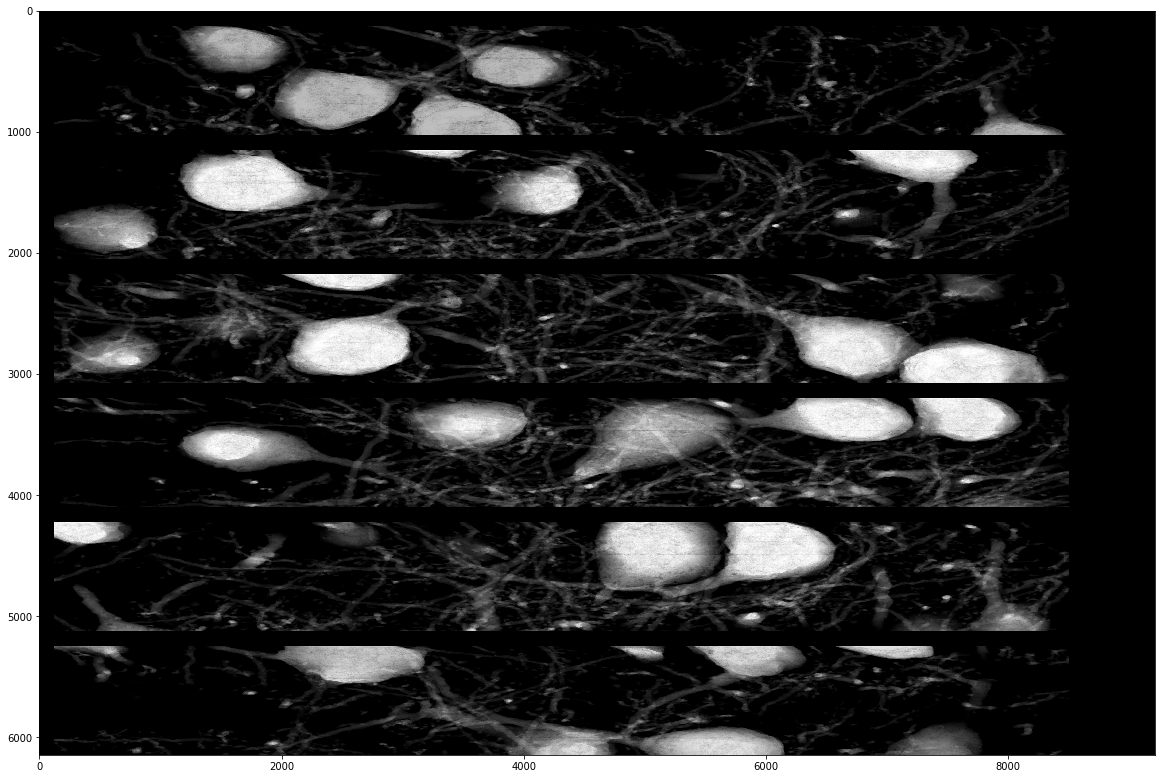

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
plt.imshow(top_down_view, cmap='gray')

# Assemble the volume

cluster = KubeCluster.from_yaml('worker-spec.yml')
cluster
client = Client(cluster)

Assemble a volume from each of the chunks. We will then be able to manipulate the data as though it is one big array. We locally cache the data for faster access.

In [13]:
my_dataarray.to_zarr??

Signature:
my_dataarray.to_zarr(
    store: Union[MutableMapping, str, pathlib.Path] = None,
    mode: str = None,
    synchronizer=None,
    group: str = None,
    encoding: Mapping = None,
    compute: bool = True,
    consolidated: bool = False,
    append_dim: Hashable = None,
) -> 'ZarrStore'
Source:   
    def to_zarr(
        self,
        store: Union[MutableMapping, str, Path] = None,
        mode: str = None,
        synchronizer=None,
        group: str = None,
        encoding: Mapping = None,
        compute: bool = True,
        consolidated: bool = False,
        append_dim: Hashable = None,
    ) -> "ZarrStore":
        """Write dataset contents to a zarr group.

        .. note:: Experimental
                  The Zarr backend is new and experimental. Please report any
                  unexpected behavior via github issues.

        Parameters
        ----------
        store : MutableMapping, str or Path, optional
            Store or path to directory in file system

In [9]:
!ls -al ../zarr2/neuron_labels

total 89008
drwxr-sr-x 2 jovyan users     4096 Jan 19 18:40 .
drwxr-sr-x 3 jovyan users     4096 Jan 19 18:40 ..
-rw-r--r-- 1 jovyan users  7982020 Jan 19 18:39 0.0.0
-rw-r--r-- 1 jovyan users 34308326 Jan 19 18:39 0.0.1
-rw-r--r-- 1 jovyan users 32403449 Jan 19 18:39 0.0.2
-rw-r--r-- 1 jovyan users 16428809 Jan 19 18:40 0.0.3
-rw-r--r-- 1 jovyan users      374 Jan 19 18:39 .zarray
-rw-r--r-- 1 jovyan users       74 Jan 19 18:39 .zattrs


In [11]:
!ls -al ../cache/l4dense/neuron-volume/

total 2378408
drwxrwsr-x 2 jovyan users    12288 Jan 19 17:40 .
drwxrwsr-x 3 jovyan users     4096 Jan 19 17:38 ..
-rw-rw-r-- 1 jovyan users  3106641 Jan 19 17:39 x0y0z0.hdf5
-rw-rw-r-- 1 jovyan users 12304535 Jan 19 17:39 x0y0z1.hdf5
-rw-rw-r-- 1 jovyan users 11043067 Jan 19 17:39 x0y0z2.hdf5
-rw-rw-r-- 1 jovyan users  5655721 Jan 19 17:39 x0y0z3.hdf5
-rw-rw-r-- 1 jovyan users 13903319 Jan 19 17:39 x0y1z0.hdf5
-rw-rw-r-- 1 jovyan users 12749134 Jan 19 17:39 x0y1z1.hdf5
-rw-rw-r-- 1 jovyan users 11126265 Jan 19 17:40 x0y1z2.hdf5
-rw-rw-r-- 1 jovyan users  1798895 Jan 19 17:39 x0y1z3.hdf5
-rw-rw-r-- 1 jovyan users 16867400 Jan 19 17:39 x0y2z0.hdf5
-rw-rw-r-- 1 jovyan users 15752380 Jan 19 17:40 x0y2z1.hdf5
-rw-rw-r-- 1 jovyan users 17329766 Jan 19 17:39 x0y2z2.hdf5
-rw-rw-r-- 1 jovyan users  2037125 Jan 19 17:39 x0y2z3.hdf5
-rw-rw-r-- 1 jovyan users 20466347 Jan 19 17:40 x0y3z0.hdf5
-rw-rw-r-- 1 jovyan users 17009832 Jan 19 17:40 x0y3z1.hdf5
-rw-rw-r-- 1 jovyan users 13272158 Jan 19 17:

In [9]:
overhead_view = zs.sum(axis=2).compute()

distributed.scheduler - INFO - Remove worker tcp://10.36.4.2:40461
distributed.core - INFO - Removing comms to tcp://10.36.4.2:40461
distributed.scheduler - INFO - Remove worker tcp://10.36.2.2:33601
distributed.core - INFO - Removing comms to tcp://10.36.2.2:33601
distributed.scheduler - INFO - Remove worker tcp://10.36.3.2:39757
distributed.core - INFO - Removing comms to tcp://10.36.3.2:39757
distributed.scheduler - INFO - Remove worker tcp://10.36.1.2:37267
distributed.core - INFO - Removing comms to tcp://10.36.1.2:37267
distributed.scheduler - INFO - Lost all workers
distributed.scheduler - INFO - Register tcp://10.36.4.2:40461
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.36.4.2:40461
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.36.2.2:33601
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.36.2.2:33601
distributed.core - INFO - Starting established connection
distribute

KilledWorker: ('array-original-df8e406cc57f60632284ec00c414f282', <Worker 'tcp://10.36.4.2:40461', memory: 0, processing: 4>)

In [16]:
overhead_view = zs.sum(axis=2).compute()

KeyboardInterrupt: 

In [44]:
my_dataarray

<xarray.Dataset>
Dimensions:        (x: 1024, y: 1024, z: 1024)
Dimensions without coordinates: x, y, z
Data variables:
    neuron_labels  (x, y, z) uint8 dask.array<chunksize=(1024, 1024, 1024), meta=np.ndarray>

In [46]:
my_dataarray.to_zarr(store=gcsmap)

ModuleNotFoundError: No module named 'zarr'

dask.array<array, shape=(1024, 1024, 1024), dtype=uint8, chunksize=(1024, 1024, 1024), chunktype=numpy.ndarray>

In [11]:
import gcsfs

ds = xr.Dataset()

# write to the bucket
ds.to_zarr(store=gcsmap)
# read it back
ds_gcs = xr.open_zarr(gcsmap)

In [29]:
x.sum().compute()

0